In [1]:
# importing packages
import pandas
import numpy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, roc_curve, plot_confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

import matplotlib.pyplot as plt

import pickle

import json

In [4]:
# reading in train and test datasets
train = pandas.read_csv("../data/train_bal.csv")
test = pandas.read_csv("../data/test.csv")

In [5]:
train = train.dropna()
label_train = train["Revenue"]
train = train.drop(columns=["Revenue"])

test = test.dropna()
label_test = test["Revenue"]
test = test.drop(columns=["Revenue"])

## take top 50% features
original_col = ['ExitRates', 'ProductRelated_Duration', 'PageValues', 'BounceRates']
        
train = train[original_col]
test = test[original_col]

In [6]:
def evaluate_model(model, test, label_test):
    predicted = model.predict(test)
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))

    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
   
    print("f1", str(f1_score(label_test, predicted, average='weighted')))
    
    print("metrics.roc_auc_score", str(roc_auc_score(label_test, predicted, average='weighted')))

    
    plot_confusion_matrix(model, test, label_test,
                      display_labels=list(set(label_test)),
                      cmap=plt.cm.Blues)
    
    classification = classification_report(label_test, predicted)
    print(classification)

In [7]:
def roc_plot(clf, X_test, y_test):
  y_pred_proba = clf.predict_proba(X_test)[::,1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.show()

### Random Forest Classifier

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
accuracy: 0.8686771761480466
precision: 0.8700854152706263
recall: 0.8686771761480466
f1 0.8685521306689938
metrics.roc_auc_score 0.8686771761480466
              precision    recall  f1-score   support

       False       0.85      0.90      0.87      7295
        True       0.89      0.84      0.86      7295

    accuracy                           0.87     14590
   macro avg       0.87      0.87      0.87     14590
weighted avg       0.87      0.87    

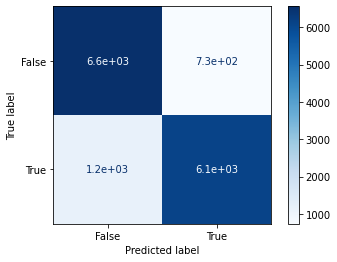

In [ ]:
rfc_parameters = {'n_estimators': [50, 100, 200],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [3,4,5,6,7],
                'criterion' :['gini', 'entropy'],
                'random_state': [42]}

rfc_model = RandomForestClassifier()

rfc_model = GridSearchCV(rfc_model, rfc_parameters, scoring='roc_auc')

rfc_model = rfc_model.fit(train, label_train)

print(rfc_model.best_estimator_)

evaluate_model(rfc_model, train, label_train) ##!!

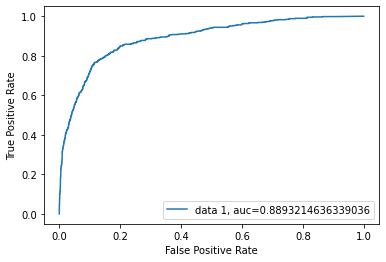

In [ ]:
roc_plot(rfc_model, test, label_test)

In [ ]:
print(rfc_model.best_estimator_.feature_importances_)
print(rfc_model.best_score_)

[0.12970066 0.10933771 0.72657601 0.03438562]
0.9349079077607213


### Logistic Regression

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy: 0.819876627827279
precision: 0.8288952646154845
recall: 0.819876627827279
f1 0.8186333138885453
metrics.roc_auc_score 0.819876627827279
              precision    recall  f1-score   support

       False       0.77      0.90      0.83      7295
        True       0.88      0.74      0.80      7295

    accuracy                           0.82     14590
   macro avg       0.83      0.82      0.82     14590
weighted avg       0.83      0.82      0.82     14590



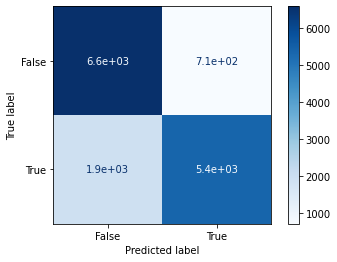

In [ ]:
logreg_parameters = {
    "fit_intercept": [True, False],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "C": numpy.logspace(-3,3,7) }

logreg_model = LogisticRegression(random_state = 42)
logreg_model = GridSearchCV(logreg_model, logreg_parameters, scoring='roc_auc')

logreg_model = logreg_model.fit(train, label_train)

print(logreg_model.best_estimator_)

evaluate_model(logreg_model, train, label_train) ##!!


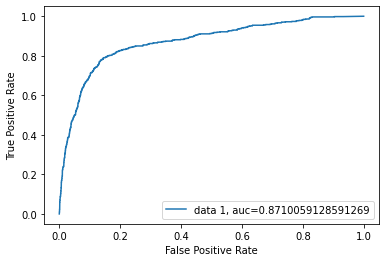

In [ ]:
roc_plot(logreg_model, test, label_test) 

In [ ]:
print(logreg_model.best_estimator_.coef_)
print(logreg_model.best_score_)

[[-0.77489976  0.37741562  2.08248191 -0.03956327]]
0.8879521638047223


### XGB Classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=2,
              gamma=1, learning_rate=1.0, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=200, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
accuracy: 0.8953392734749829
precision: 0.895376725663903
recall: 0.8953392734749829
f1 0.8953367949109479
metrics.roc_auc_score 0.8953392734749829
              precision    recall  f1-score   support

       False       0.89      0.90      0.90      7295
        True       0.90      0.89      0.89      7295

    accuracy                           0.90     14590
   macro avg       0.90      0.90      0.90     14590
weighted avg       0.90      0.90      0.90     14590



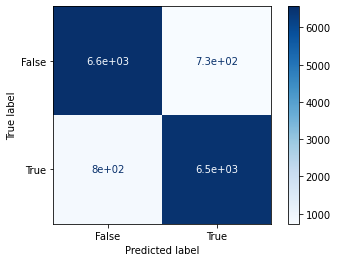

In [ ]:
xgb_params = {'max_depth': [3,4,5,6], 
              'learning_rate': [x/10 for x in list(range(1,11))],
              'n_estimators': [50, 100, 200],
              'objective': ['binary:logistic']}

xgb_model = xgb.XGBClassifier(early_stopping_rounds=2, gamma=1, random_state=42, reg_lambda=200)
xgb_model = GridSearchCV(xgb_model, xgb_params, scoring='roc_auc')
xgb_model.fit(train, label_train)
print(xgb_model.best_estimator_)
evaluate_model(xgb_model, train, label_train) ##!!

accuracy: 0.8642876453095432
precision: 0.8899923883921861
recall: 0.8642876453095432
f1 0.8731143255811362
metrics.roc_auc_score 0.8233105637566782
              precision    recall  f1-score   support

       False       0.95      0.88      0.92      3127
        True       0.54      0.76      0.64       572

    accuracy                           0.86      3699
   macro avg       0.75      0.82      0.78      3699
weighted avg       0.89      0.86      0.87      3699



{'learning_rate': 1.0,
 'max_depth': 6,
 'n_estimators': 100,
 'objective': 'binary:logistic'}

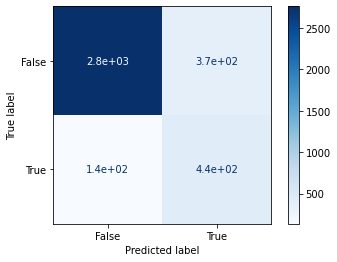

In [ ]:
evaluate_model(xgb_model, test, label_test)
xgb_model.best_params_

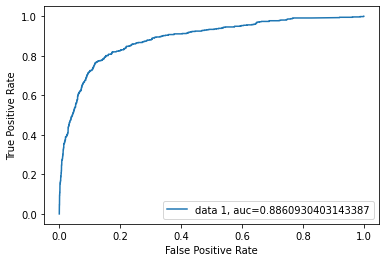

In [ ]:
roc_plot(xgb_model, test, label_test) 

In [ ]:
print(xgb_model.best_estimator_.feature_importances_)
print(xgb_model.best_score_)

[0.0373185  0.03978648 0.8863113  0.03658368]
0.937591776315944


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
accuracy: 0.8733379026730638
precision: 0.8735407574529089
recall: 0.8733379026730638
f1 0.8733207040808272
metrics.roc_auc_score 0.8733379026730639
              precision    recall  f1-score   support

       False       0.86      0.88      0.87      7295
        True       0.88      0.86      0.87      7295

    accuracy                           0.87     14590
   macro avg       0.87      0.87      0.87     14590
weighted avg       0.87      0.87      0.87     14590



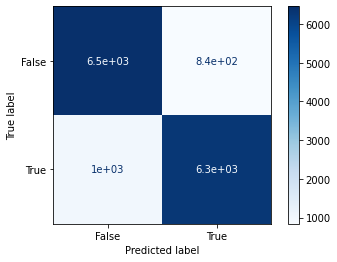

In [ ]:


dt_params = {"criterion":['gini','entropy'],
             'max_depth':[3,4,5,6,7,8],
             'random_state': [42]}

dt_model = DecisionTreeClassifier()
dt_model = GridSearchCV(dt_model, dt_params, scoring='roc_auc')
dt_model.fit(train, label_train)
print(dt_model.best_estimator_)
evaluate_model(dt_model, train, label_train) ##!!

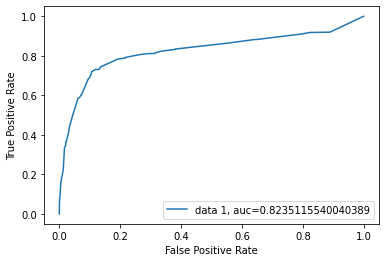

In [ ]:
roc_plot(dt_model, test, label_test)

In [ ]:
print(dt_model.best_estimator_.feature_importances_)
print(dt_model.best_score_)

[0.0499193  0.09306375 0.82979134 0.02722561]
0.917803794932167


### Evaluation

In [ ]:
method_dict = {
    'LogReg': logreg_model.best_score_,
    'RandomForest': rfc_model.best_score_,
    'XGB': xgb_model.best_score_,
    'DecisionTree': dt_model.best_score_
}

In [ ]:
def plotSuccess():
    s = pandas.Series(method_dict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot.bar(capsize=4, rot=0)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([0, 1])
    plt.xlabel('Method')
    plt.ylabel('ROC AUC')
    plt.title('ROC AUC of Methods')
     
    plt.show()

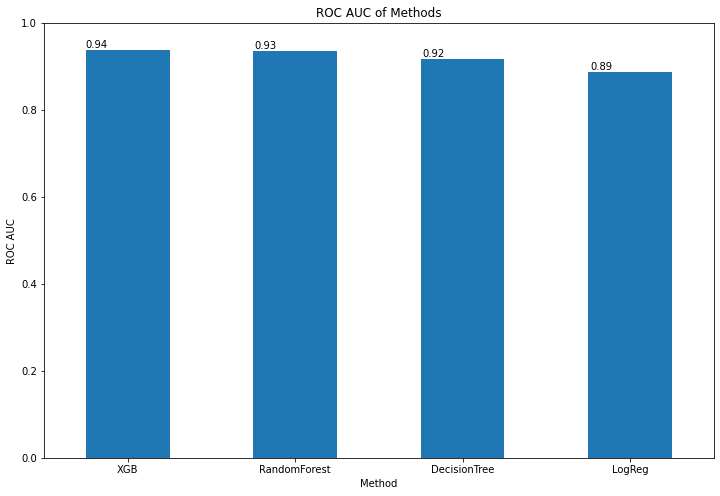

In [ ]:
plotSuccess()

accuracy: 0.8642876453095432
precision: 0.8899923883921861
recall: 0.8642876453095432
f1 0.8731143255811362
metrics.roc_auc_score 0.8233105637566782
              precision    recall  f1-score   support

       False       0.95      0.88      0.92      3127
        True       0.54      0.76      0.64       572

    accuracy                           0.86      3699
   macro avg       0.75      0.82      0.78      3699
weighted avg       0.89      0.86      0.87      3699



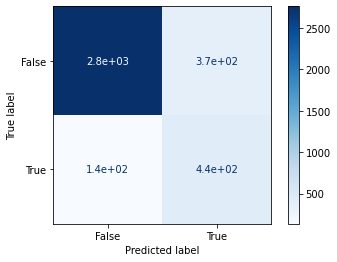

In [ ]:
evaluate_model(xgb_model, test, label_test)

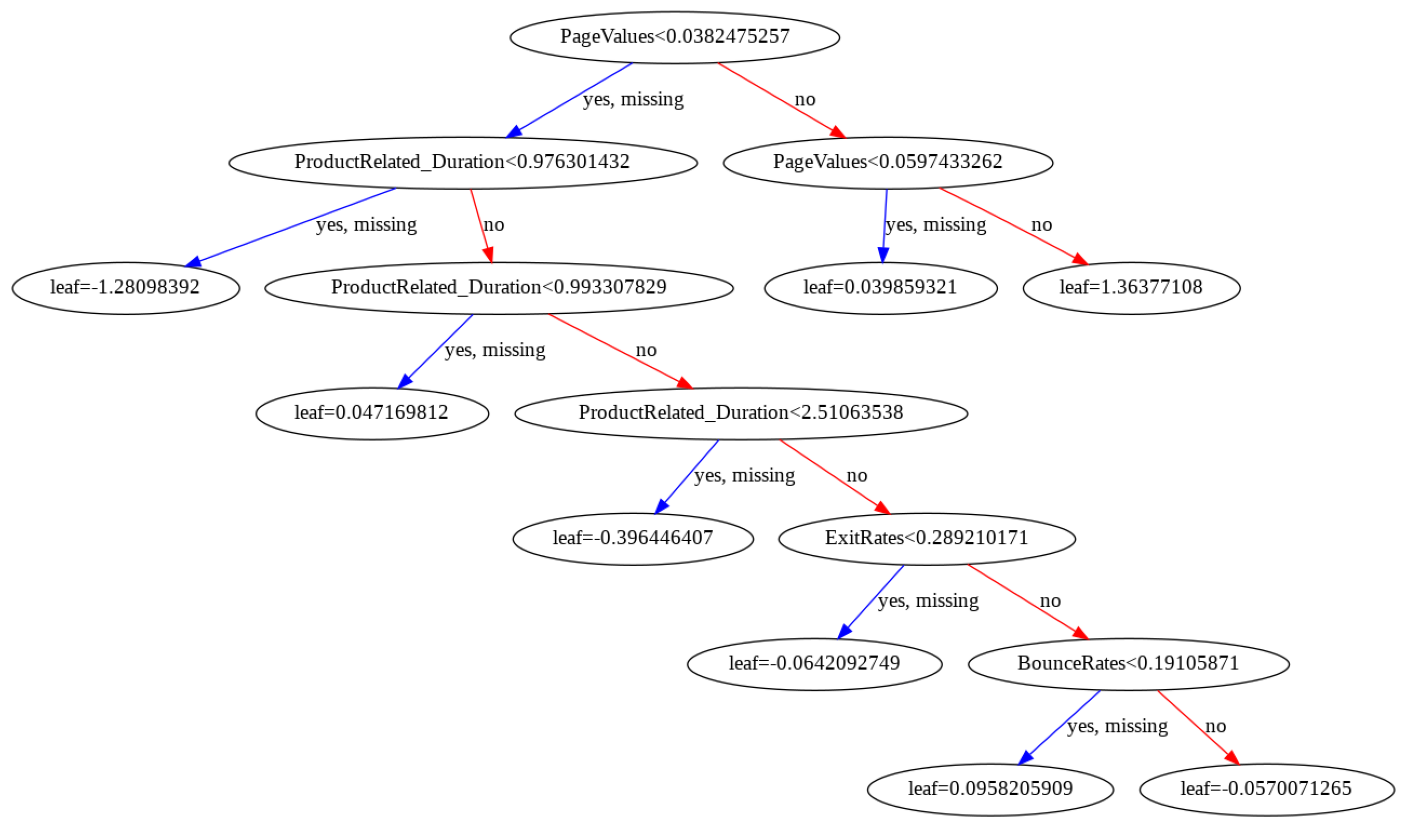

In [ ]:
# from xgboost import plot_tree
# plot_tree(xgb_model.best_estimator_)
# fig = plt.gcf()
# fig.set_size_inches(30, 15)

In [16]:
col_dict = {'columns': original_col}
with open('../trained_models/transaction_pred.json', 'w') as f:
    json.dump(col_dict, f)

In [17]:
# save the model to disk
filename = '../trained_models/transaction_pred.sav'
pickle.dump(xgb_model, open(filename, 'wb'))